In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fonts_sample = pd.read_csv('fonts_sample.csv')
fonts_sample = fonts_sample['Font'].tolist()
print('\u001b[38;5;19m', 'Выведем список используемых шрифтов:', '\u001b[0m')
for i in sorted(fonts_sample):
    print('\u001b[38;5;19m', i, '\u001b[0m')

 Выведем список используемых шрифтов: 
 Aguante 
 Alumni Sans Collegiate One Italic 
 Alumni Sans Collegiate One Regular 
 Ambidexter 
 Aref Ruqaa Ink Bold 
 Aref Ruqaa Ink Regular 
 BRASS MONO Bold 
 BRASS MONO Bold Italic 
 BRASS MONO Bold Regular 
 BRASS MONO Italic 
 Better VCR 5.2 
 Ganesha Type Regular 
 Ghastly Panic 
 Realest Extended 
 Tana Uncial SP 


**По результатам первой части иследования получены изображения букв и символов предоставленных шрифтов. Присутствуют малозначимые символы изображения которые могут не идентифицироваться с конкретным шрифтом. Использование их при построении модели приведет к неточностям. Создадим список наименований этих символов и удалим их из данных для обучения.**

In [4]:
excess_index=[]
for  i in range(1, 13+1):
    excess_index.append(i)
excess_index.append(15+1)
excess_index.append(19+1)
excess_index.append(20+1)
for  i in range(225, 227+1):
    excess_index.append(i)
excess_index.append(230)
excess_index.append(234)
for  i in range(239, 244+1):
    excess_index.append(i)
excess_index.append(246+1)
for  i in range(321, 326+1):
    excess_index.append(i)
for  i in range(363, 369+1):
    excess_index.append(i)
excess_index.append(547+1)
for  i in range(574, 580+1):
    excess_index.append(i)
excess_index.append(583+1)
excess_index.append(584+1)
excess_index.append(598+1)
excess_index.append(599+1)
for  i in range(654, 659+1):
    excess_index.append(i)
for  i in range(662, 664+1):
    excess_index.append(i)
for  i in range(669, 671+1):
    excess_index.append(i)
for  i in range(745, 750+1):
    excess_index.append(i)
for  i in range(813, 822+1):
    excess_index.append(i)
excess_index.append(895+1)
excess_index.append(896+1)
excess_index.append(899+1)
excess_index.append(904+1)
excess_index.append(906+1)
excess_index.append(913+1)
for  i in range(927, 938+1):
    excess_index.append(i)

In [5]:
df_fonts = pd.read_csv('df_fonts.csv')
display(df_fonts.head(10).style.background_gradient(cmap='Blues', axis=0))

,Letter,Font
0,1.jpg,Aguante
1,2.jpg,Aguante
2,3.jpg,Aguante
3,4.jpg,Aguante
4,5.jpg,Aguante
5,6.jpg,Aguante
6,7.jpg,Aguante
7,8.jpg,Aguante
8,9.jpg,Aguante
9,10.jpg,Aguante


In [6]:
data = pd.DataFrame(df_fonts, columns=['Font'])
data = data.reset_index()
del data['index']
data.head(10)

,Font
0,Aguante
1,Aguante
2,Aguante
3,Aguante
4,Aguante
5,Aguante
6,Aguante
7,Aguante
8,Aguante
9,Aguante


In [7]:
images_list = []
for i in range(1, len(data)+1):
    img_path = 'fonts_sample_img/'+str(i)+'.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    images_list.append(img)

In [8]:
X = np.array(images_list)/255
X = X.astype('float32')

In [9]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder. fit_transform(data[['Font']]). toarray ())
data_df = data.join(encoder_df)
data_df.drop('Font', axis= 1, inplace= True )
data_new = data_df.values

In [10]:
(X_train, X_test, y_train, y_test) = train_test_split(X, data_new, test_size=0.25, random_state=42)

In [11]:
model = Sequential([
    Flatten(input_shape=(414, 414)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(15, activation='softmax')
])
lr=0.01
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 171396)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      21,938,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,948,047 (83.73 MB)

 Trainable params: 21,948,047 (83.73 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
history = model.fit(X_train, y_train,
          epochs=100,
          validation_data=(X_test, y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.0749 - loss: 83.6019 - val_accuracy: 0.1358 - val_loss: 25.6093
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.1358 - loss: 16.8174 - val_accuracy: 0.1774 - val_loss: 10.8417
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.2420 - loss: 8.1327 - val_accuracy: 0.2189 - val_loss: 8.8771
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.3174 - loss: 6.1246 - val_accuracy: 0.3057 - val_loss: 6.3363
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.3510 - loss: 5.1444 - val_accuracy: 0.3283 - val_loss: 5.3016
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.4177 - loss: 3.8732 - val_accuracy: 0.3057 - val_loss: 5.2814
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.3923 - loss: 4.9273 - val_accuracy: 0.3245 - val_loss: 8.5695
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.4464 - loss: 5.1179 - val_

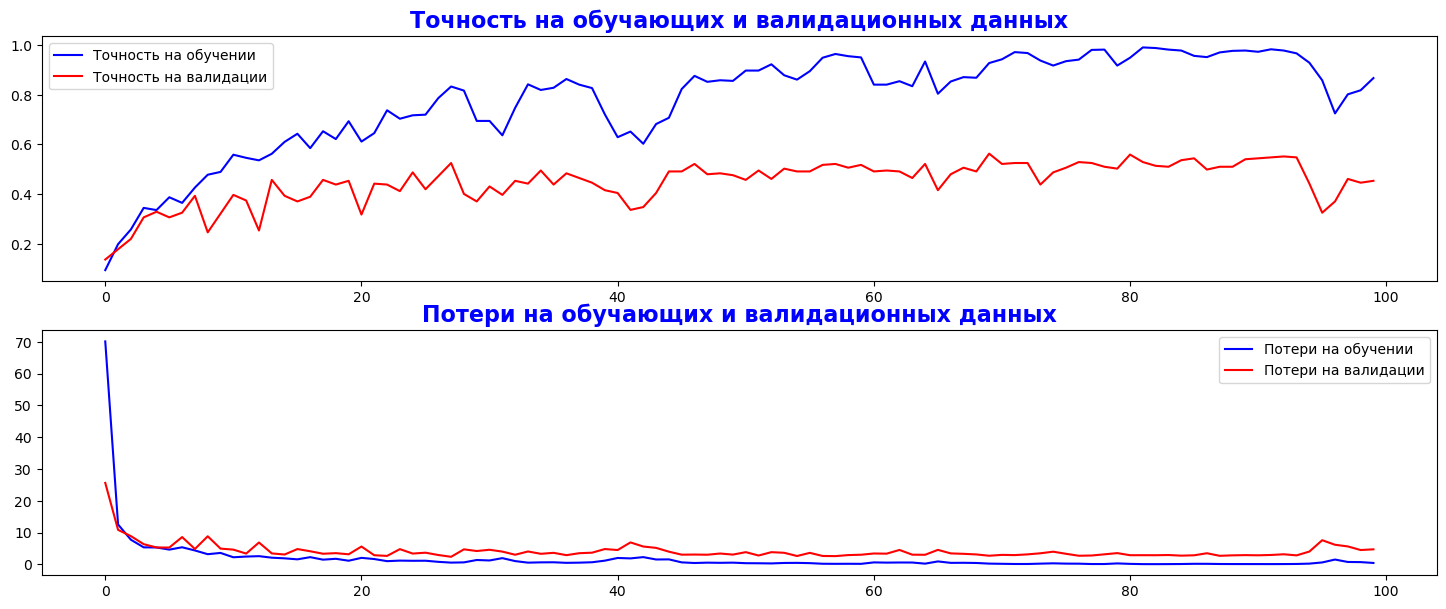

In [13]:
plt.figure(figsize=(18, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label = 'Точность на обучении', color='blue')
plt.plot(history.history['val_accuracy'], label = 'Точность на валидации', color='red')
plt.legend()
plt.title('Точность на обучающих и валидационных данных', fontsize=16, fontweight="bold", color='blue')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label = 'Потери на обучении', color='blue')
plt.plot(history.history['val_loss'], label = 'Потери на валидации', color='red')
plt.legend()
plt.title('Потери на обучающих и валидационных данных', fontsize=16, fontweight="bold", color='blue')
plt.show()

In [14]:
model.save('model_kvant_1.h5')

In [15]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

In [16]:
print('\u001b[38;5;19m', 'Точность на обучении max (accuracy) =', max(accuracy), '\u001b[0m')

 Точность на обучении max (accuracy) = 0.989924430847168 


In [17]:
print('\u001b[38;5;19m', 'Точность на валидации max (accuracy) =', max(val_accuracy), '\u001b[0m')

 Точность на валидации max (accuracy) = 0.5622641444206238 
